In [1]:
import csv
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import chess
import chess.pgn
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.utils import shuffle

C:\Users\Christopher.Atkeson\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Following Board Representation from Paper
def bit_board_encoder(board):
    bit_boards = {"P": np.zeros(64),"N": np.zeros(64),"B": np.zeros(64),
                  "R": np.zeros(64),"Q": np.zeros(64),"K": np.zeros(64),
                  "p": np.zeros(64),"n": np.zeros(64),"b": np.zeros(64),
                  "r": np.zeros(64),"q": np.zeros(64),"k": np.zeros(64)}
    for i in range(0, 64):
        square = board.piece_at(i)
        if square is not None:
            if square.symbol().isupper():
                bit_boards[square.symbol()][i] = 1
            else:
                bit_boards[square.symbol()][i] = 1
            
    bit_board = np.concatenate([bit_boards["P"], bit_boards["R"], bit_boards["N"], bit_boards["B"], 
                                bit_boards["Q"], bit_boards["K"], bit_boards["p"], bit_boards["r"],
                                bit_boards["n"], bit_boards["b"], bit_boards["q"], bit_boards["k"]])
    return bit_board

#All Pieces on one board
def board_encoder(board):
    board_rep = np.zeros(64);
    for i in range(0, 64):
        square = board.piece_at(i)
        if square is not None:
            board_rep[i] = {"P": 1,"N": 3,"B": 3.3,
                            "R": 5,"Q": 9.5,"K": 10,
                            "p": 1,"n": 3,"b": 3.3,
                            "r": 5,"q": 9.5,"k": 10}[square.symbol()]
            
    return board_rep


In [77]:
stockfish = pandas.read_csv('C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\stockfish.csv')
pgn = open('C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\data.pgn')
#stockfish = pandas.read_csv('/Users/chrisatkeson/Documents/web_project/chess_evaluation/stockfish.csv')
#pgn = open('/Users/chrisatkeson/Documents/web_project/chess_evaluation/data.pgn')

In [78]:
#Ignore 0s because they take up to much of the dataset and skew results 

stockfish_evaluations = stockfish['MoveScores'];
evaluations = [];
positions =[];

count = 0
for game in stockfish_evaluations:
    count = count+1
    if count % 500 == 0:
        print(count)
    position = chess.pgn.read_game(pgn)
    for evaluation in game.split():
        if evaluation.isdigit():
            if(float(evaluation) != 0):
                evaluations.append([float(evaluation)])
                positions.append(position.board())
        elif evaluation.lstrip('-').isdigit():
            if(float(evaluation) != 0):
                evaluations.append([float(evaluation.lstrip('-'))*-1.0])
                positions.append(position.board())
        
        next_position = position.variations[0]
        position = next_position

    if count == 5000:
        break
        

500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [79]:
#normalize evaluations      
standard_dev = np.std(evaluations)
mean_evaluation = np.mean(evaluations)
#Unit Variance and 0 mean
evaluations = (np.asarray(evaluations) - mean_evaluation)/standard_dev

#normalized_evaluations = all_evaluations * 1/max_abs_evaluation
evaluations = np.tanh(evaluations)

#Constuct Board Vectors
for x in range(0,len(positions)):
    positions[x] = (bit_board_encoder(positions[x]))
    
positions, evaluations = shuffle(positions, evaluations, random_state=0)

num_rows = len(positions)
num_cols_x = 768
num_cols_y = 1

X = np.zeros((num_rows,num_cols_x))
Y = np.zeros((num_rows,num_cols_y))

for k in range(0,num_rows):
    X[k,:] = positions[k][:]
    Y[k,:] = evaluations[k][:]

X_train = X[0:300000]
X_test = X[300001:400000]

Y_train = Y[0:300000]
Y_test = Y[300001:400000]

In [80]:
#Keras Model

n_input = 768 # 12 8x8 chessboards

model = Sequential()
model.add(Dense(800, activation = 'relu', input_shape=(n_input,)))
model.add(Dense(400, activation = 'relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1,activation='tanh'))

model.compile(optimizer='rmsprop',
              loss='mse')

model.fit(X_train, Y_train, epochs=5, batch_size=100)

Epoch 1/5
300000/300000 [==============================] - 44s 145us/step - loss: 0.0352
Epoch 2/5
300000/300000 [==============================] - 44s 146us/step - loss: 0.0140
Epoch 3/5
300000/300000 [==============================] - 44s 146us/step - loss: 0.0093
Epoch 4/5
300000/300000 [==============================] - 45s 150us/step - loss: 0.0071
Epoch 5/5
300000/300000 [==============================] - 46s 152us/step - loss: 0.0059


In [81]:
#Random: 0.005
score = model.evaluate(X_test, Y_test, batch_size=50)
print(score)
predictions = model.predict(X_test)

85607/85607 [==============================] - 5s 55us/step
0.009530195673327663


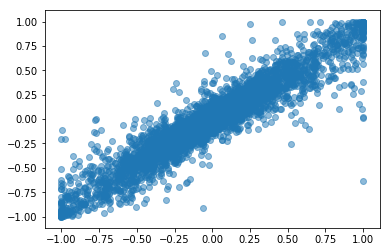

In [87]:
# GET RID OF THE N/A VALUES THAT YOU LEFT AS ZERO
plt.scatter(Y_test[0:10000], predictions[0:10000], alpha=0.5)
plt.show()

In [59]:


np.savetxt("Y_test.csv", Y_test, delimiter=",")
np.savetxt("Predictions.csv", predictions, delimiter=",")

In [56]:
print(Y_test[519], predictions[519], mean_evaluation)

[-0.06183914] [0.651704] 42.09941498860767


In [158]:
# Neural Net
learning_rate = 0.01

# Network Parameters
n_hidden_1 = 100 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
n_input = 768 # 12 8x8 chessboards
n_classes = 1

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, 1])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Create model
def multilayer_perceptron(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    out_layer = tf.nn.tanh(out_layer)
    return out_layer

In [118]:
# Construct model
output = multilayer_perceptron(X)
# using mean squared error cost function
cost  = tf.square(output - Y)
# using Gradient Descent algorithm
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    cost_history=[]
    
    for step in np.arange(1):
        for x in range(0,100):
            start = x*100
            end = start+999
            sess.run(optimizer, feed_dict={X:positions[start:end], Y:normalized_evaluations[start:end]})
            cost_history = np.append(cost_history, sess.run(cost,feed_dict={X:positions[start:end], Y:normalized_evaluations[start:end]}))
    
        print(cost_history)



[0.99159807 1.01985145 1.01022673 ... 0.92674917 0.95122498 1.        ]


In [37]:
print(normalized_evaluations)

[0.00145725 0.0013763  0.0009715  ... 0.83273964 0.83273964 0.83330635]
